In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
sns.set(rc = {'figure.figsize':(10, 6)})
pd.set_option("precision", 3)

The history saving thread hit an unexpected error (OperationalError('no such table: history')).History will not be written to the database.


In [2]:
folder = "/home/jarobyte/scratch/guemes/icdar/cz/baseline/experiments/"

In [3]:
files = os.listdir(folder)
len(files)

13

In [4]:
logs = pd.concat([pd.read_csv(folder + f) 
                       for f in tqdm(os.listdir(folder))])\
.assign(dropout = lambda df: df.dropout.round(2))
print(logs.shape)
logs.head()

  0%|          | 0/13 [00:00<?, ?it/s]

(610, 21)


,epoch,train_loss,train_error_rate,dev_loss,dev_error_rate,training_minutes,learning_rate,weight_decay,model,max_sequence_length,...,feedforward_dimension,encoder_layers,decoder_layers,attention_heads,activation,dropout,parameters,encoder_tokens,decoder_tokens,experiment_id
0,1,0.481,14.772,0.276,10.313,4.408,1.000e-04,1.000e-04,Transformer,110,...,2048,2,2,8,relu,0.1,15044786,178,178,22694258_5
1,2,0.095,5.515,0.255,9.247,8.894,1.000e-04,1.000e-04,Transformer,110,...,2048,2,2,8,relu,0.1,15044786,178,178,22694258_5
2,3,0.066,4.835,0.268,9.014,13.385,1.000e-04,1.000e-04,Transformer,110,...,2048,2,2,8,relu,0.1,15044786,178,178,22694258_5
3,4,0.051,4.450,0.277,8.790,17.869,1.000e-04,1.000e-04,Transformer,110,...,2048,2,2,8,relu,0.1,15044786,178,178,22694258_5
4,5,0.042,4.204,0.284,8.682,22.343,1.000e-04,1.000e-04,Transformer,110,...,2048,2,2,8,relu,0.1,15044786,178,178,22694258_5


In [5]:
experiments = logs\
.assign(fit = lambda df: df.apply(lambda r: {k:r[k] for k in ["train_loss", 
                                                              "dev_loss", 
                                                              "epoch"]}, 
                                  axis = 1))\
.groupby("experiment_id")\
.agg({"fit":(lambda x: min(x, key = lambda y: y["dev_loss"])),
      "parameters":max, 
      "dropout":max,
      "weight_decay":max,
      "embedding_dimension":max,
      "encoder_layers":max,
      "training_minutes":max})\
.assign(parameters = lambda df: df.parameters / 10**6, 
        train_loss = lambda df: df.fit.map(lambda x: x["train_loss"]),
        dev_loss = lambda df: df.fit.map(lambda x: x["dev_loss"]),
        epoch = lambda df: df.fit.map(lambda x: x["epoch"]))\
.drop(columns = "fit")
experiments.head(10)

,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
experiment_id,,,,,,,,,
22694258_1,15.045,0.3,1.000e-04,512,2,219.237,0.099,0.272,5
22694258_10,15.045,0.5,1.000e-03,512,2,216.653,0.234,0.342,25
22694258_11,15.045,0.4,1.000e-02,512,2,223.981,2.541,2.595,39
22694258_12,15.045,0.2,1.000e-02,512,2,218.615,2.461,2.551,44
22694258_2,15.045,0.1,1.000e-02,512,2,222.726,2.432,2.572,42
22694258_3,15.045,0.2,1.000e-03,512,2,219.785,0.144,0.305,16
22694258_4,15.045,0.3,1.000e-02,512,2,218.776,2.511,2.577,47
22694258_5,15.045,0.1,1.000e-04,512,2,218.905,0.095,0.255,2
22694258_6,15.045,0.2,1.000e-02,512,2,219.702,2.516,2.596,43


# evaluation

In [6]:
evaluation_folder = "/home/jarobyte/scratch/guemes/icdar/cz/baseline/evaluation/"

In [7]:
evaluation_files = os.listdir(evaluation_folder)
len(evaluation_files)

13

In [8]:
evaluation = pd.concat([pd.read_csv(evaluation_folder + f) 
                       for f in tqdm(os.listdir(evaluation_folder))])
print(evaluation.shape)
evaluation.head()

  0%|          | 0/13 [00:00<?, ?it/s]

(130, 9)


,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting
0,22694258_5,35.546,disjoint,greedy,100,3.924,10.568,6.812,NaN
1,22694258_5,27.364,disjoint,greedy,50,2.119,10.568,7.676,NaN
2,22694258_5,35.192,disjoint,beam,100,14.937,10.568,6.849,NaN
3,22694258_5,27.912,disjoint,beam,50,9.038,10.568,7.619,NaN
4,22694258_5,45.992,sliding,greedy,50,69.051,10.568,5.708,uniform


In [9]:
results = evaluation.merge(experiments, right_index = True, left_on = "experiment_id")\
.sort_values("improvement", ascending = False)
results.head(20)

,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
8,22694258_5,47.029,sliding,beam,50,404.461,10.568,5.598,triangle,15.045,0.1,1.000e-04,512,2,218.905,0.095,0.255,2
9,22694258_5,46.892,sliding,beam,50,404.444,10.568,5.613,bell,15.045,0.1,1.000e-04,512,2,218.905,0.095,0.255,2
5,22694258_5,46.343,sliding,greedy,50,69.056,10.568,5.671,triangle,15.045,0.1,1.000e-04,512,2,218.905,0.095,0.255,2
7,22694258_5,46.295,sliding,beam,50,404.442,10.568,5.676,uniform,15.045,0.1,1.000e-04,512,2,218.905,0.095,0.255,2
6,22694258_5,46.240,sliding,greedy,50,69.039,10.568,5.682,bell,15.045,0.1,1.000e-04,512,2,218.905,0.095,0.255,2
4,22694258_5,45.992,sliding,greedy,50,69.051,10.568,5.708,uniform,15.045,0.1,1.000e-04,512,2,218.905,0.095,0.255,2
8,22694258_7,44.995,sliding,beam,50,419.710,10.568,5.813,triangle,15.045,0.1,1.000e-04,512,2,222.213,0.101,0.276,2
5,22694258_7,44.968,sliding,greedy,50,69.701,10.568,5.816,triangle,15.045,0.1,1.000e-04,512,2,222.213,0.101,0.276,2
6,22694258_7,44.726,sliding,greedy,50,70.582,10.568,5.841,bell,15.045,0.1,1.000e-04,512,2,222.213,0.101,0.276,2
9,22694258_7,44.617,sliding,beam,50,425.546,10.568,5.853,bell,15.045,0.1,1.000e-04,512,2,222.213,0.101,0.276,2


<AxesSubplot:>

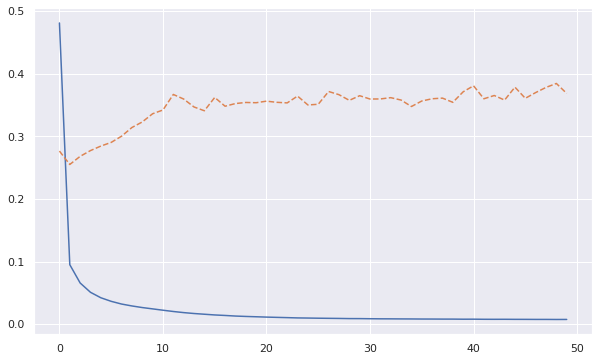

In [10]:
logs.query("experiment_id == '22694258_5'").train_loss.plot()
logs.query("experiment_id == '22694258_5'").dev_loss.plot(ls = "--")

In [11]:
results.query("experiment_id == '22694258_5'")\
[["experiment_id", "window", "window_size", "decoding", "weighting", "improvement"]]\
.sort_values(["window", "window_size", "decoding", "weighting"])\
.pivot(index = "experiment_id", 
       values = "improvement", 
       columns = ["window", "window_size", "decoding", "weighting"])

window        disjoint                         sliding                   \
window_size        50              100             50                     
decoding          beam  greedy    beam  greedy    beam                    
weighting          NaN     NaN     NaN     NaN    bell triangle uniform   
experiment_id                                                             
22694258_5      27.912  27.364  35.192  35.546  46.892   47.029  46.295   

window                                 
window_size                            
decoding      greedy                   
weighting       bell triangle uniform  
experiment_id                          
22694258_5     46.24   46.343  45.992